# Sentosa

## Group 09 BDA06

### Import Functions

In [1]:
#import
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patheffects as path_effects

### Configurations

In [2]:
pd.set_option('display.max_columns', None) # Show all the columns in dataframes

In [3]:
config={       
   
    "TIDY_DATES": ['Open Timestamp'], #list of columns to be formatted into datetime data types
 
}

### Functions to be used in this section

In [4]:
def get_tidy_dates(df, config):    
    """
    Format the dates to specific format
    Inputs      : df     = dataframe where dates have to be formatted
                : config = list of date columns
    outputs     : model data frame with formatted date columns
    """
    
    df[config['TIDY_DATES']]=df[config['TIDY_DATES']].apply(pd.to_datetime,format='%d/%m/%Y %p %I:%M:%S')
        
    return df

In [5]:
def get_time_of_day(df):
    
    """
    Create time of the day for the date column
    Inputs      : df      = sdc_df, bus ridership data
    outputs     : df, updated data frame with a new column called "TIME_OF_DAY"
    """   
    
    
    df['TIME_OF_DAY']=np.where(((df['Open Timestamp'].dt.hour>=16) & (df['Open Timestamp'].dt.hour<23)),"Evening",
                            np.where(((df['Open Timestamp'].dt.hour>=7) & (df['Open Timestamp'].dt.hour<12)),"Morning",
                                            np.where(((df['Open Timestamp'].dt.hour>=12) & (df['Open Timestamp'].dt.hour<16)),"Afternoon",
                                                    "Night")))
    
    return df

In [6]:
def get_time_related_features(df):
    """
    Get a dataframe creating all time/seasonality related features on a given date column
    Inputs      : df      = Sentosa dataframe 
    outputs     : Updated data frame with all new time/seasonality features created
    """
    
    #time seasonality    
    df['MONTH_OF_YEAR']=df['Open Timestamp'].dt.month
    df['DAY_OF_MONTH']=df['Open Timestamp'].dt.day
    df['WEEK_OF_YEAR']=df['Open Timestamp'].dt.isocalendar().week
    df['YEAR']=df['Open Timestamp'].dt.year
    df['QUARTER_OF_YEAR']=df['Open Timestamp'].dt.quarter
    df['IS_YEAR_START']=np.where(df.MONTH_OF_YEAR<3,1,0)
    df['IS_YEAR_END']=np.where(df.MONTH_OF_YEAR>10,1,0)
    df['DAY_OF_WEEK']=df['Open Timestamp'].dt.weekday
    df['HOUR_OF_DAY']=df['Open Timestamp'].dt.hour
    df['MINS_OF_HOUR']=df['Open Timestamp'].dt.minute
    df['SECS_OF_MINUTE']=df['Open Timestamp'].dt.second
    df['NAME_OF_DAY']=df['Open Timestamp'].dt.day_name()
    df['DATE']=df['Open Timestamp'].dt.date
   
    df['WEEKEND']=np.where(df['Open Timestamp'].dt.weekday>=5,1,0)
    
    return df

In [7]:
def loc_null_rows(df):
    """
    Get a display of the number of null values in a dataframe
    Inputs      : df
    outputs     : table display of columns with null values
    """
    for col in df.columns:
        if df[col].isnull().sum()!=0:
            display(df.loc[df[col].isnull()])

In [8]:
def drop_df_rows(df,dfr,inplace=True):
    """
    drop rows from a dataframe with a filtered dataframe
    Inputs      : df: Dataframe to drop from, dfr: Filtered dataframe to drop
    outputs     : df with dropped rows
    """    
    print(f'Shape of removed data frame: {dfr.shape}') 
    try:
        print('Shape before dropping:',df.shape)
        df.drop(dfr.index, inplace=inplace)
        print('Shape after dropping:',df.shape)
        print(dfr.shape[0],"rows dropped\n")
    except:
        print("0 rows dropped\n")

In [9]:
def rename_ridership_busstops(df):
    """
    rename mismatched names of ridership df
    Inputs      : df (sentosa ridership df)
    outputs     : df with bus stops renamed
    """    
    # renaming mismatched bus stops
    df.replace({'Bus Stop':{'Opp Village Hotel':'Opp Village Hotel (Opp Merlion Plaza)',
                            'Opp Merlion Plaza':'Opp Village Hotel (Opp Merlion Plaza)',
                            'Opp So Spa (Former)':'Opp So Spa',
                            'Merlion Plaza':'Village Hotel (Merlion Plaza)',
                            'Village Hotel':'Village Hotel (Merlion Plaza)'
                        }},inplace=True)
    return df

In [10]:
def get_unmatched_stops_and_routes_df(df):
    """
    Function to drop rows of data that was identified to be not helpful in model building
    Inputs      : df
    outputs     : table display of columns with null values
    """    
    # creating a dataframe from rows that we are removing for now, can be amended in future
    # bus stops that are not in bus list
    removed_df=df.loc[df['Bus Stop'].isin(['Unmatched Stop', 
                                           'Coach Park',
                                           'HarbourFront Int',
                                           'Sentosa Gateway',
                                           'SDC Office',                      
                                           'SDC Bus Depot',                   
                                           'Sentosa Golf Club Entrance',      
                                           'VivoCity',                        
                                           'Ficus Tree Roundabout',            
                                           'So Spa'     
                                          ])|
                                            # routes that are not in bus list
                      df['Route'].isin(['No Route',
                                        'Chartered Route',
                                        'Bus Route D'
                                       ])
                     ]
    return removed_df

In [11]:
def get_weather(df,weather_df):
    """
    function to add weather to dataframe
    Inputs      : Sentosa dataframe after time related features added; weather dataframe with daily weather data
    outputs     : dataframe with daily weather added
    """   
    df = df.merge(weather_df, on=['YEAR','MONTH_OF_YEAR','DAY_OF_MONTH'], how='left')
    return df

In [12]:
def get_hourlyweather(df,hourlyweather_df):
    """
    function to add hourly weather to dataframe    
    Inputs      : Sentosa dataframe after time related features added; weather dataframe with hourly weather data
    outputs     : dataframe with hourly weather added
    """   
    df= df.merge(hourlyweather_df, 
                 on=['YEAR','MONTH_OF_YEAR','DAY_OF_MONTH','HOUR_OF_DAY'], 
                 how='left').set_index(df.index)

    return df

## Start of Data Cleaning

### Dataframes import

In [13]:
# import files

ridership_path = os.path.join("data","Bus_Ridership_Jan-Mar21_type2_Shared.csv")
attractions_path = os.path.join("data","SDC-BCG Capstone Project Details.xlsx")
bus_stops_path = os.path.join("data","SDC-BCG Capstone Project Details.xlsx")
janweather_path = os.path.join("data","Daily Weather Data","DAILYDATA_S60_202101.csv")
febweather_path = os.path.join("data","Daily Weather Data","DAILYDATA_S60_202102.csv")
marweather_path = os.path.join("data","Daily Weather Data","DAILYDATA_S60_202103.csv")
hourlyweather_path =os.path.join("data","Daily Weather Data","Weather.xlsx")

ridership_df_src = pd.read_csv(ridership_path)
attractions_df = pd.read_excel(attractions_path,"List")
bus_stops_df = pd.read_excel(bus_stops_path,"Bus Service Details")
janweather_df = pd.read_csv(janweather_path)
febweather_df = pd.read_csv(febweather_path)
marweather_df = pd.read_csv(marweather_path)
hourlyweather_df = pd.read_excel(hourlyweather_path,"Hourly_Weather")

df_dict={'Ridership Data': ridership_df_src,
         'Attractions Data' : attractions_df,
         'Bus Stops Data': bus_stops_df,
         'Jan Weather' : janweather_df,
         'Feb Weather' : febweather_df,
         'Mar Weather' : marweather_df,
         'Hourly Weather':hourlyweather_df}

### Add Time Related features to ridership

In [14]:
ridership_df=get_tidy_dates(ridership_df_src.copy(),config)
ridership_df=get_time_of_day(ridership_df)
ridership_df=get_time_related_features(ridership_df)

In [15]:
ridership_df['TIME_OF_DAY'].value_counts()

Evening      108006
Afternoon     58511
Morning       56007
Night         15822
Name: TIME_OF_DAY, dtype: int64

In [16]:
ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238346 entries, 0 to 238345
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Adult In            238346 non-null  int64         
 1   Adult Out           238346 non-null  int64         
 2   Bus No              238346 non-null  int64         
 3   Bus Stop            238346 non-null  object        
 4   Child In            238346 non-null  int64         
 5   Child Out           238346 non-null  int64         
 6   Day / Month / Year  238346 non-null  object        
 7   Month / Year        238346 non-null  object        
 8   Open Timestamp      238346 non-null  datetime64[ns]
 9   Route               238346 non-null  object        
 10  Total In            238346 non-null  int64         
 11  Total Out           238346 non-null  int64         
 12  TIME_OF_DAY         238346 non-null  object        
 13  MONTH_OF_YEAR       238346 no

### Check for Null Values

In [17]:
for key in df_dict:
    if df_dict[key].isnull().sum().sum()>0:
        print(key)
        display(df_dict[key].isnull().sum())

Attractions Data


Places/ Location          0
Sector                    0
F&B Type                153
Gated Attraction        195
Zone                      0
Area/ Island Partner    145
Lat                       0
Long                      0
Remarks                 230
dtype: int64

Bus Stops Data


No                                0
Route                             0
Bus Stops                         0
Lat                               1
Long                              1
Route Sequence                    0
Attractions/ Landmarks nearby     1
Amenities nearby                 24
Nearby F&B                        5
Remarks                          18
Bus Operation Details            21
dtype: int64

In [18]:
loc_null_rows(bus_stops_df)

,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
20,21,Bus Route B,W Hotel / Quayside Isle,NaN,NaN,5,W Hotel/ Quayside Isle,Supermarket - Jason The Gourmet Grocer\nRetail...,Dining at Quayside Isle\nBlue Lotus\nGin Khao ...,NaN,Note that bus B wil not call at W hotel/ Quasi...


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
20,21,Bus Route B,W Hotel / Quayside Isle,NaN,NaN,5,W Hotel/ Quayside Isle,Supermarket - Jason The Gourmet Grocer\nRetail...,Dining at Quayside Isle\nBlue Lotus\nGin Khao ...,NaN,Note that bus B wil not call at W hotel/ Quasi...


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
31,32,Bus Route D,Harbourfront,1.267177,103.818807,2,NaN,NaN,NaN,NaN,Harbourfront Bus interchange


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
1,2,Bus Route A,Imbiah Lookout,1.255487,103.816093,2,"4D Adventureland, Skyline Luge, MegaAdventure,...",NaN,Starbucks,Some of the Attractions have retail outlets an...,NaN
2,3,Bus Route A,Siloso Point,1.257684,103.811304,3,"Fort Siloso, Fort Siloso Skywalk,\nCoastal Wal...",NaN,Dessert Kiosks: Co+nut+Ink\nCasual Dining: Tra...,Pop up food track at Siloso Point over some we...,NaN
3,4,Bus Route A,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,4,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Op...,NaN
4,5,Bus Route A,Opp Amara Sanctuary Resort,1.252729,103.822999,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
6,7,Bus Route A,Amara Sanctuary Resort,1.252527,103.822588,7,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
7,8,Bus Route A,Village Hotel (Merlion Plaza),1.253595,103.820404,8,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Me...,NaN
9,10,Bus Route C,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,2,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,NaN,NaN
10,11,Bus Route C,Opp Amara Sanctuary Resort,1.252729,103.822999,3,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
12,13,Bus Route C,Amara Sanctuary Resort,1.252527,103.822588,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
13,14,Bus Route C,Village Hotel (Merlion Plaza),1.253595,103.820404,6,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Me...,NaN


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
19,20,Bus Route B,Sentosa Pavilion,1.249025,103.828418,4,Eton House/ Sentosa Office/ Sentosa Golf Club ...,NaN,NaN,NaN,Non-attraction area
22,23,Bus Route B,Opp Sentosa Pavilion,1.248822,103.828335,7,Eton House/ Sentosa Office/ Sentosa Golf Club ...,NaN,NaN,NaN,Non-attraction area
24,25,Bus Route B,Eton House,1.247923,103.827618,9,Eton House,NaN,NaN,NaN,Non-attraction area
30,31,Bus Route D,Beach Station,1.251592,103.818568,1,"Siloso Beach, Palawan Green, Palawan Beach, if...",NaN,NaN,NaN,Bus Route D is normally deployed during peak d...
31,32,Bus Route D,Harbourfront,1.267177,103.818807,2,NaN,NaN,NaN,NaN,Harbourfront Bus interchange


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
4,5,Bus Route A,Opp Amara Sanctuary Resort,1.252729,103.822999,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
6,7,Bus Route A,Amara Sanctuary Resort,1.252527,103.822588,7,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
9,10,Bus Route C,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,2,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,NaN,NaN
10,11,Bus Route C,Opp Amara Sanctuary Resort,1.252729,103.822999,3,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
12,13,Bus Route C,Amara Sanctuary Resort,1.252527,103.822588,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
18,19,Bus Route B,Opp Amara Sanctuary Resort,1.252729,103.822999,3,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
19,20,Bus Route B,Sentosa Pavilion,1.249025,103.828418,4,Eton House/ Sentosa Office/ Sentosa Golf Club ...,NaN,NaN,NaN,Non-attraction area
20,21,Bus Route B,W Hotel / Quayside Isle,NaN,NaN,5,W Hotel/ Quayside Isle,Supermarket - Jason The Gourmet Grocer\nRetail...,Dining at Quayside Isle\nBlue Lotus\nGin Khao ...,NaN,Note that bus B wil not call at W hotel/ Quasi...
21,22,Bus Route B,Sentosa Cove Village,1.246874,103.839254,6,"Cove Village, 1 Degree 15 Marina",Cove Village Car Parks\nSupermarket - Coldstor...,Dining at Cove Village\neM By the Marina\n\nDi...,NaN,NaN
22,23,Bus Route B,Opp Sentosa Pavilion,1.248822,103.828335,7,Eton House/ Sentosa Office/ Sentosa Golf Club ...,NaN,NaN,NaN,Non-attraction area


,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details
1,2,Bus Route A,Imbiah Lookout,1.255487,103.816093,2,"4D Adventureland, Skyline Luge, MegaAdventure,...",NaN,Starbucks,Some of the Attractions have retail outlets an...,NaN
2,3,Bus Route A,Siloso Point,1.257684,103.811304,3,"Fort Siloso, Fort Siloso Skywalk,\nCoastal Wal...",NaN,Dessert Kiosks: Co+nut+Ink\nCasual Dining: Tra...,Pop up food track at Siloso Point over some we...,NaN
3,4,Bus Route A,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,4,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Op...,NaN
4,5,Bus Route A,Opp Amara Sanctuary Resort,1.252729,103.822999,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
5,6,Bus Route A,Resorts World Sentosa,1.253571,103.825741,6,"Univeral Studios Singapore, Trick Eye Museum, ...","Retail - Candylicious, Garrett Popcorn, Bee Ch...","Kiosks/ Desserts: Liho, Iiao Iiao, Krispy Krem...",Note that adventure cove and dolphin island is...,NaN
6,7,Bus Route A,Amara Sanctuary Resort,1.252527,103.822588,7,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
7,8,Bus Route A,Village Hotel (Merlion Plaza),1.253595,103.820404,8,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Me...,NaN
9,10,Bus Route C,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,2,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,NaN,NaN
10,11,Bus Route C,Opp Amara Sanctuary Resort,1.252729,103.822999,3,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN
11,12,Bus Route C,Resorts World Sentosa,1.253571,103.825741,4,"Univeral Studios Singapore, Trick Eye Museum, ...","Retail - Candylicious, Garrett Popcorn, Bee Ch...","Kiosks/ Desserts: Liho, Iiao Iiao, Krispy Krem...",Note that adventure cove and dolphin island is...,NaN


We see that the Lat and Long values for bus stop W Hotel / Quayside Isle is missing.<br>
We can impute the correct values from Google Maps which are 1.24639 and 103.84246.<br>
Source: https://www.google.com/maps/d/edit?mid=1u2Ej746lZMbDctnjikHcPxYKaXn2Dnrn&ll=1.2496024802795032%2C103.82473596282959&z=15

In [19]:
# Impute Lat and Long values
# bus_stops_df[bus_stops_df['Bus Stops']=='W Hotel / Quayside Isle'].replace({'Lat':{np.nan:1.24639},'Long':{np.nan:103.84246}})

bus_stops_df.loc[bus_stops_df.loc[bus_stops_df['Bus Stops']=='W Hotel / Quayside Isle'].index,'Lat']=1.24639
bus_stops_df.loc[bus_stops_df.loc[bus_stops_df['Bus Stops']=='W Hotel / Quayside Isle'].index,'Long']=103.84246

# bus_stops_df[bus_stops_df['Bus Stops']=='W Hotel / Quayside Isle']

In [20]:
ridership_df.info()
bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238346 entries, 0 to 238345
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Adult In            238346 non-null  int64         
 1   Adult Out           238346 non-null  int64         
 2   Bus No              238346 non-null  int64         
 3   Bus Stop            238346 non-null  object        
 4   Child In            238346 non-null  int64         
 5   Child Out           238346 non-null  int64         
 6   Day / Month / Year  238346 non-null  object        
 7   Month / Year        238346 non-null  object        
 8   Open Timestamp      238346 non-null  datetime64[ns]
 9   Route               238346 non-null  object        
 10  Total In            238346 non-null  int64         
 11  Total Out           238346 non-null  int64         
 12  TIME_OF_DAY         238346 non-null  object        
 13  MONTH_OF_YEAR       238346 no

### Merge ridership into bus stops
In this next section we will be testing to merge the two dataframes on bus stops and route.

In [21]:
# Choosing the data to merge on
ride_test_df=ridership_df[['Bus Stop','Route']]
bus_test_df=bus_stops_df[['Bus Stops','Route','Lat','Long']]
bus_test_df=bus_test_df.rename(columns={'Bus Stops':'Bus Stop'})

merge_test_df=ride_test_df.merge(bus_test_df,on=['Bus Stop','Route'],how='outer')
merge_test_df.drop_duplicates(inplace=True)
display(merge_test_df.isnull().sum())

display(merge_test_df.loc[merge_test_df.Lat.isnull()])

Bus Stop     0
Route        0
Lat         72
Long        72
dtype: int64

,Bus Stop,Route,Lat,Long
52298,Opp Merlion Plaza,Bus Route A,NaN,NaN
82198,Unmatched Stop,No Route,NaN,NaN
92507,Merlion Plaza,Bus Route B,NaN,NaN
104601,Opp Merlion Plaza,Bus Route C,NaN,NaN
127879,Merlion Plaza,Bus Route A,NaN,NaN
...,...,...,...,...
238293,SDC Bus Depot,Chartered Route,NaN,NaN
238295,Opp Village Hotel,No Route,NaN,NaN
238312,Village Hotel,No Route,NaN,NaN
238333,Opp So Spa (Former),No Route,NaN,NaN


There are some null values in the lat and long columns, we shall explore bus stop values that do not exist in the bus stops dataframe.

In [22]:
ride_not_in_df=ridership_df.copy()
bus_not_in_df=bus_stops_df.copy()

print(ridership_df.shape)
print(ride_not_in_df.shape)

(238346, 27)
(238346, 27)


In [23]:
stops_not_in_df = ride_not_in_df[['Bus Stop']].loc[~ride_not_in_df['Bus Stop'].isin(bus_not_in_df['Bus Stops'])]
#bus_not_in_df.drop_duplicates(inplace=True)
print(stops_not_in_df.value_counts())
print(bus_not_in_df[['Bus Stops','Route']])

Bus Stop                  
Merlion Plaza                 17883
Opp Merlion Plaza             15961
Unmatched Stop                10715
Coach Park                     3186
Village Hotel                  2483
Opp Village Hotel              2229
HarbourFront Int                911
Sentosa Gateway                 694
SDC Office                      606
SDC Bus Depot                   507
Sentosa Golf Club Entrance      236
VivoCity                        236
Opp So Spa (Former)             123
Ficus Tree Roundabout            26
So Spa                            2
dtype: int64
                                Bus Stops        Route
0                           Beach Station  Bus Route A
1                          Imbiah Lookout  Bus Route A
2                            Siloso Point  Bus Route A
3   Opp Village Hotel (Opp Merlion Plaza)  Bus Route A
4              Opp Amara Sanctuary Resort  Bus Route A
5                   Resorts World Sentosa  Bus Route A
6                  Amara Sanctuary 

We see some bus stops that is named differently in the ridership data, we shall rename them to match.

In [24]:
ride_not_in_df=rename_ridership_busstops(ride_not_in_df)

There are some unmatched stops that does not exist in the bus stops data, we shall temporarily remove them.

In [25]:
removed_df=get_unmatched_stops_and_routes_df(ride_not_in_df)
drop_df_rows(ride_not_in_df,removed_df)

Shape of removed data frame: (20989, 27)
Shape before dropping: (238346, 27)
Shape after dropping: (217357, 27)
20989 rows dropped



In [26]:
# Check for bus stops / routes mismatch
for value in ride_not_in_df['Route'].unique():
    a_ride_not_in_df=ride_not_in_df.loc[ride_not_in_df['Route']==value]
    a_bus_not_in_df=bus_stops_df.loc[bus_stops_df['Route']==value]
    a_stops_not_in_df = a_ride_not_in_df[['Bus Stop','Route']].loc[~a_ride_not_in_df['Bus Stop'].isin(a_bus_not_in_df['Bus Stops'])]
    print(a_stops_not_in_df.value_counts())

Bus Stop               Route      
Resorts World Sentosa  Bus Route B    5
dtype: int64
Series([], dtype: int64)
Series([], dtype: int64)


In [27]:
# remove Harbourfront Bus Route B
mismatch_stop_df=ride_not_in_df.loc[(ride_not_in_df['Bus Stop']=='Harbourfront')&(ride_not_in_df['Route']=='Bus Route B')]
# add rows to be removed to 
removed_df=removed_df.append(mismatch_stop_df)
drop_df_rows(ride_not_in_df,mismatch_stop_df)

Shape of removed data frame: (0, 27)
Shape before dropping: (217357, 27)
Shape after dropping: (217357, 27)
0 rows dropped



In [28]:
# remove Resorts World Sentosa Bus Route B
mismatch_stop_df=ride_not_in_df.loc[(ride_not_in_df['Bus Stop']=='Resorts World Sentosa')&(ride_not_in_df['Route']=='Bus Route B')]
# add rows to be removed to 
removed_df=removed_df.append(mismatch_stop_df)
drop_df_rows(ride_not_in_df,mismatch_stop_df)

Shape of removed data frame: (5, 27)
Shape before dropping: (217357, 27)
Shape after dropping: (217352, 27)
5 rows dropped



In [29]:
# remove Harbourfront Bus Route C
mismatch_stop_df=ride_not_in_df.loc[(ride_not_in_df['Bus Stop']=='Harbourfront')&(ride_not_in_df['Route']=='Bus Route C')]
# add rows to be removed to 
removed_df=removed_df.append(mismatch_stop_df)
drop_df_rows(ride_not_in_df,mismatch_stop_df)

Shape of removed data frame: (0, 27)
Shape before dropping: (217352, 27)
Shape after dropping: (217352, 27)
0 rows dropped



In [30]:
# remove Village Hotel (Merlion Plaza) Bus Route D
mismatch_stop_df=ride_not_in_df.loc[(ride_not_in_df['Bus Stop']=='Village Hotel (Merlion Plaza)')&(ride_not_in_df['Route']=='Bus Route D')]
# add rows to be removed to 
removed_df=removed_df.append(mismatch_stop_df)
drop_df_rows(ride_not_in_df,mismatch_stop_df)

Shape of removed data frame: (0, 27)
Shape before dropping: (217352, 27)
Shape after dropping: (217352, 27)
0 rows dropped



### Results from testing
We found some values that needed to be cleaned and created functions above to address said issues.

## Creating clean bus stops dataframe

After exploring, we shall apply some of the found issues to the main dataframe.<br> First, we need to rename the bus stops in ridership_df to match with the bus stops in bus_stops_df.

In [31]:
ridership_df=rename_ridership_busstops(ridership_df)

In [32]:
rider_group=pd.DataFrame(ridership_df.groupby(by=['Route','Bus Stop']).agg("sum")[['Total In','Total Out']])

clean_bus_stops_df= bus_stops_df.merge(rider_group,
                               left_on=['Route','Bus Stops'], 
                               right_on=['Route','Bus Stop'],
                               how='left'
                              )
# remove Opp So Spa (former) bus stop since we will not be using it
drop_df_rows(clean_bus_stops_df,clean_bus_stops_df[clean_bus_stops_df['Bus Stops']=='Opp So Spa (former)'],inplace=True)
# remove Route D bus stops since we will not be using them
drop_df_rows(clean_bus_stops_df,clean_bus_stops_df[clean_bus_stops_df['Route']=='Bus Route D'],inplace=True)
# reset index numbers
clean_bus_stops_df.reset_index(inplace=True,drop=True)
display(clean_bus_stops_df)

Shape of removed data frame: (1, 13)
Shape before dropping: (32, 13)
Shape after dropping: (31, 13)
1 rows dropped

Shape of removed data frame: (2, 13)
Shape before dropping: (31, 13)
Shape after dropping: (29, 13)
2 rows dropped



,No,Route,Bus Stops,Lat,Long,Route Sequence,Attractions/ Landmarks nearby,Amenities nearby,Nearby F&B,Remarks,Bus Operation Details,Total In,Total Out
0,1,Bus Route A,Beach Station,1.251592,103.818568,1,"Siloso Beach, Palawan Green, Palawan Beach, if...",Beach Station Tram Stop\n(Palawan> Tanjong Bou...,"Kiosks: Liho, Old Chang Kee\nCafé/ Coffeehouse...",Wings of Time is temporary closed\n\nPop up fo...,Bus A details - 7am to 12.10 am daily at 15 mi...,22706.0,10728.0
1,2,Bus Route A,Imbiah Lookout,1.255487,103.816093,2,"4D Adventureland, Skyline Luge, MegaAdventure,...",NaN,Starbucks,Some of the Attractions have retail outlets an...,NaN,14231.0,12822.0
2,3,Bus Route A,Siloso Point,1.257684,103.811304,3,"Fort Siloso, Fort Siloso Skywalk,\nCoastal Wal...",NaN,Dessert Kiosks: Co+nut+Ink\nCasual Dining: Tra...,Pop up food track at Siloso Point over some we...,NaN,8743.0,10212.0
3,4,Bus Route A,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,4,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Op...,NaN,406.0,2061.0
4,5,Bus Route A,Opp Amara Sanctuary Resort,1.252729,103.822999,5,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN,1462.0,2680.0
5,6,Bus Route A,Resorts World Sentosa,1.253571,103.825741,6,"Univeral Studios Singapore, Trick Eye Museum, ...","Retail - Candylicious, Garrett Popcorn, Bee Ch...","Kiosks/ Desserts: Liho, Iiao Iiao, Krispy Krem...",Note that adventure cove and dolphin island is...,NaN,5228.0,14829.0
6,7,Bus Route A,Amara Sanctuary Resort,1.252527,103.822588,7,"Amara Hotel, Capella Hotel",NaN,Dining at Amara\nShutters\nTier Bar\n\nDining ...,NaN,NaN,863.0,1076.0
7,8,Bus Route A,Village Hotel (Merlion Plaza),1.253595,103.820404,8,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,Note that this bus stop used to be named as Me...,NaN,1274.0,636.0
8,9,Bus Route C,Beach Station,1.251592,103.818568,1,"Siloso Beach, Palawan Green, Palawan Beach, if...",Beach Station Tram Stop\n(Palawan> Tanjong Bou...,"Kiosks: Liho, Old Chang Kee\nCafé/ Coffeehouse...",Wings of Time is temporary closed\n\nPop up fo...,Bus C details - 8am to 10pm daily at 15 mins i...,8164.0,26305.0
9,10,Bus Route C,Opp Village Hotel (Opp Merlion Plaza),1.253324,103.821181,2,"Imbiah Sentosa Express Station, Village Hotel,...",NaN,Dining at Far East Hotels\nMess Hall\nRoyal Ta...,NaN,NaN,271.0,267.0


## Creating clean ridership DataFrame

### Adding daily weather to ridership_df

In [33]:
# Combine weather dataframes, ignore_index to reset the index
weather_df = janweather_df.append(other = [febweather_df,marweather_df],ignore_index=True) 
weather_df.rename(columns={"Year":"YEAR","Month": "MONTH_OF_YEAR", "Day": "DAY_OF_MONTH"},inplace=True)
display(weather_df)

,Station,YEAR,MONTH_OF_YEAR,DAY_OF_MONTH,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Sentosa Island,2021,1,1,76.8,15.0,21.8,32.4,24.3,26.5,22.1,5.4,36.3
1,Sentosa Island,2021,1,2,117.0,10.2,17.6,32.4,23.3,26.0,22.0,5.6,33.9
2,Sentosa Island,2021,1,3,-,-,-,-,26.4,29.5,24.0,3.8,23.7
3,Sentosa Island,2021,1,4,-,-,-,-,27.0,31.4,25.3,4.4,24.8
4,Sentosa Island,2021,1,5,-,-,-,-,26.6,29.9,23.9,5.4,26.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Sentosa Island,2021,3,27,1.8,1.2,1.2,1.8,27.5,31.7,24.7,5.1,38.2
86,Sentosa Island,2021,3,28,0.0,0.0,0.0,0.0,29.0,32.2,26.2,5.4,18.3
87,Sentosa Island,2021,3,29,55.0,34.4,41.4,53.2,27.4,33.0,23.4,4.1,40.7
88,Sentosa Island,2021,3,30,0.0,0.0,0.0,0.0,28.7,33.6,25.6,5.2,24.1


In [34]:
ridership_df=get_weather(ridership_df,weather_df)
ridership_df.head()

,Adult In,Adult Out,Bus No,Bus Stop,Child In,Child Out,Day / Month / Year,Month / Year,Open Timestamp,Route,Total In,Total Out,TIME_OF_DAY,MONTH_OF_YEAR,DAY_OF_MONTH,WEEK_OF_YEAR,YEAR,QUARTER_OF_YEAR,IS_YEAR_START,IS_YEAR_END,DAY_OF_WEEK,HOUR_OF_DAY,MINS_OF_HOUR,SECS_OF_MINUTE,NAME_OF_DAY,DATE,WEEKEND,Station,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,0,0,1,Palawan Beach,0,0,20/1/2021,Jan-21,2021-01-20 13:36:54,Bus Route B,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,36,54,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3
1,0,4,2,Siloso Point,0,0,20/1/2021,Jan-21,2021-01-20 13:38:16,Bus Route A,0,4,Afternoon,1,20,3,2021,1,1,0,2,13,38,16,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3
2,0,0,3,Resorts World Sentosa,0,0,20/1/2021,Jan-21,2021-01-20 13:37:57,Bus Route C,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,37,57,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3
3,0,1,3,Resorts World Sentosa,0,0,20/1/2021,Jan-21,2021-01-20 13:37:57,Bus Route C,0,1,Afternoon,1,20,3,2021,1,1,0,2,13,37,57,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3
4,0,0,1,Sentosa Golf Club,0,0,20/1/2021,Jan-21,2021-01-20 13:39:24,Bus Route B,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,39,24,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3


### Adding hourly weather to ridership_df

In [35]:
hourlyweather_df.head()

,YEAR,MONTH_OF_YEAR,DAY_OF_MONTH,HOUR_OF_DAY,Nowcast,Is_Rain_Flag
0,2021,1,1,0,Windy,0
1,2021,1,1,1,Windy,0
2,2021,1,1,2,Windy,0
3,2021,1,1,3,Windy,0
4,2021,1,1,4,Windy,0


In [36]:
ridership_df=get_hourlyweather(ridership_df,hourlyweather_df)
ridership_df.head()

,Adult In,Adult Out,Bus No,Bus Stop,Child In,Child Out,Day / Month / Year,Month / Year,Open Timestamp,Route,Total In,Total Out,TIME_OF_DAY,MONTH_OF_YEAR,DAY_OF_MONTH,WEEK_OF_YEAR,YEAR,QUARTER_OF_YEAR,IS_YEAR_START,IS_YEAR_END,DAY_OF_WEEK,HOUR_OF_DAY,MINS_OF_HOUR,SECS_OF_MINUTE,NAME_OF_DAY,DATE,WEEKEND,Station,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Nowcast,Is_Rain_Flag
0,0,0,1,Palawan Beach,0,0,20/1/2021,Jan-21,2021-01-20 13:36:54,Bus Route B,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,36,54,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3,Partly Cloudy (Day),0
1,0,4,2,Siloso Point,0,0,20/1/2021,Jan-21,2021-01-20 13:38:16,Bus Route A,0,4,Afternoon,1,20,3,2021,1,1,0,2,13,38,16,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3,Partly Cloudy (Day),0
2,0,0,3,Resorts World Sentosa,0,0,20/1/2021,Jan-21,2021-01-20 13:37:57,Bus Route C,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,37,57,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3,Partly Cloudy (Day),0
3,0,1,3,Resorts World Sentosa,0,0,20/1/2021,Jan-21,2021-01-20 13:37:57,Bus Route C,0,1,Afternoon,1,20,3,2021,1,1,0,2,13,37,57,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3,Partly Cloudy (Day),0
4,0,0,1,Sentosa Golf Club,0,0,20/1/2021,Jan-21,2021-01-20 13:39:24,Bus Route B,0,0,Afternoon,1,20,3,2021,1,1,0,2,13,39,24,Wednesday,2021-01-20,0,Sentosa Island,0.0,0.0,0.0,0.0,27.0,30.8,24.7,5.3,23.3,Partly Cloudy (Day),0


### Convert weather columns to float64 dtype and impute missing values.

In [37]:
# Convert weather columns to float64 dtype, errors=‘coerce’ will set invalid values like '-' as NaN
columns = ['Daily Rainfall Total (mm)','Highest 30 min Rainfall (mm)','Highest 60 min Rainfall (mm)',
           'Highest 120 min Rainfall (mm)','Mean Temperature (°C)','Maximum Temperature (°C)','Minimum Temperature (°C)',
           'Mean Wind Speed (km/h)','Max Wind Speed (km/h)']
for col in columns:
    ridership_df[col] = pd.to_numeric(ridership_df[col], errors='coerce')

We assume there was no rain when Rainfall data is NaN.

In [38]:
# Fill NaN Rainfall data with 0
ridership_df.fillna(value={'Daily Rainfall Total (mm)':0,'Highest 30 min Rainfall (mm)':0,'Highest 60 min Rainfall (mm)':0,
                  'Highest 120 min Rainfall (mm)':0},inplace=True)

In [39]:
# All NaN Mean Temperature (°C) coincides with NaN Maximum Temperature (°C) and NaN Minimum Temperature (°C)
ridership_df[ridership_df['Mean Temperature (°C)'].isnull()].isnull().sum().sort_values(ascending=False)

Minimum Temperature (°C)         12631
Maximum Temperature (°C)         12631
Mean Temperature (°C)            12631
Max Wind Speed (km/h)             9853
Mean Wind Speed (km/h)            9853
Adult In                             0
Station                              0
MINS_OF_HOUR                         0
SECS_OF_MINUTE                       0
NAME_OF_DAY                          0
DATE                                 0
WEEKEND                              0
Highest 60 min Rainfall (mm)         0
Daily Rainfall Total (mm)            0
Highest 30 min Rainfall (mm)         0
DAY_OF_WEEK                          0
Highest 120 min Rainfall (mm)        0
Nowcast                              0
HOUR_OF_DAY                          0
IS_YEAR_END                          0
Adult Out                            0
Route                                0
Bus No                               0
Bus Stop                             0
Child In                             0
Child Out                

In [40]:
# All NaN Mean Wind Speed (km/h) coincides with NaN Max Wind Speed (km/h)
ridership_df[ridership_df['Mean Wind Speed (km/h)'].isnull()].isnull().sum().sort_values(ascending=False)

Max Wind Speed (km/h)            9853
Mean Wind Speed (km/h)           9853
Minimum Temperature (°C)         9853
Maximum Temperature (°C)         9853
Mean Temperature (°C)            9853
Adult In                            0
Station                             0
MINS_OF_HOUR                        0
SECS_OF_MINUTE                      0
NAME_OF_DAY                         0
DATE                                0
WEEKEND                             0
Highest 60 min Rainfall (mm)        0
Daily Rainfall Total (mm)           0
Highest 30 min Rainfall (mm)        0
DAY_OF_WEEK                         0
Highest 120 min Rainfall (mm)       0
Nowcast                             0
HOUR_OF_DAY                         0
IS_YEAR_END                         0
Adult Out                           0
Route                               0
Bus No                              0
Bus Stop                            0
Child In                            0
Child Out                           0
Day / Month 

We can use boxplots to decide whether to use mean or median to fill NaN Temperature and Wind data.

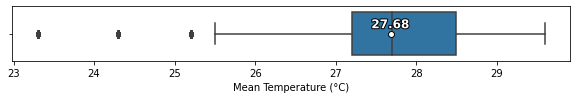

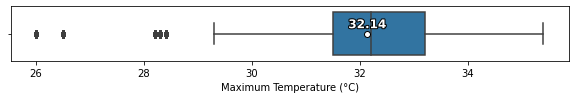

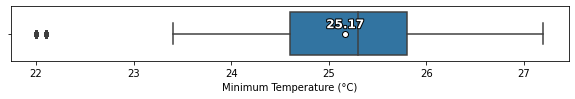

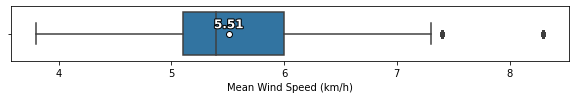

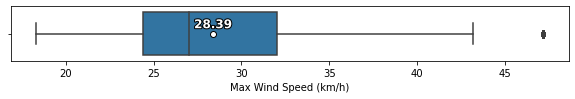

In [41]:
# Mean values are in white text
columns = ['Mean Temperature (°C)','Maximum Temperature (°C)','Minimum Temperature (°C)',
          'Mean Wind Speed (km/h)','Max Wind Speed (km/h)']
for col in columns:
    plt.figure(figsize=(10,1))
    ax = sns.boxplot(data=ridership_df,x=col,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"6"})
    means = ridership_df.mean(axis=0,numeric_only=True).round(2)[col]
    vertical_offset = -0.1 # offset from mean for display
    for ytick in ax.get_yticks():
        ax.text(means, ytick + vertical_offset, means, 
           horizontalalignment='center',size = 12,color='white',weight='semibold',
                # outline numbers
               path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),path_effects.Normal()])
    plt.show();

The distributions of Temperature and Wind data are skewed, therefore we should impute using the median values.

In [42]:
# Use median to fill NaN Temperature and Wind data
ridership_df.fillna(value=ridership_df.median(axis=0,numeric_only=True),inplace=True,axis=0)

In [43]:
# Check for any NaN values
ridership_df.isnull().sum()

Adult In                         0
Adult Out                        0
Bus No                           0
Bus Stop                         0
Child In                         0
Child Out                        0
Day / Month / Year               0
Month / Year                     0
Open Timestamp                   0
Route                            0
Total In                         0
Total Out                        0
TIME_OF_DAY                      0
MONTH_OF_YEAR                    0
DAY_OF_MONTH                     0
WEEK_OF_YEAR                     0
YEAR                             0
QUARTER_OF_YEAR                  0
IS_YEAR_START                    0
IS_YEAR_END                      0
DAY_OF_WEEK                      0
HOUR_OF_DAY                      0
MINS_OF_HOUR                     0
SECS_OF_MINUTE                   0
NAME_OF_DAY                      0
DATE                             0
WEEKEND                          0
Station                          0
Daily Rainfall Total

In [44]:
# sort ridership_df in chronological order
# ridership_df.sort_values(by='Open Timestamp',inplace=True,ignore_index=True)
# display(ridership_df.head())

### Remove some rows from ridership

In [45]:
removed_df=get_unmatched_stops_and_routes_df(ridership_df)
drop_df_rows(ridership_df,removed_df)

Shape of removed data frame: (20989, 39)
Shape before dropping: (238346, 39)
Shape after dropping: (217357, 39)
20989 rows dropped



In [46]:
# Check for bus stops / routes mismatch in ridership_df
for value in ridership_df['Route'].unique():
    a_ride_not_in_df=ridership_df.loc[ridership_df['Route']==value]
    a_bus_not_in_df=bus_stops_df.loc[bus_stops_df['Route']==value]
    a_stops_not_in_df = a_ride_not_in_df[['Bus Stop','Route']].loc[~a_ride_not_in_df['Bus Stop'].isin(a_bus_not_in_df['Bus Stops'])]
    print(a_stops_not_in_df.value_counts())

Bus Stop               Route      
Resorts World Sentosa  Bus Route B    5
dtype: int64
Series([], dtype: int64)
Series([], dtype: int64)


In [47]:
# remove Resorts World Sentosa Bus Route B
mismatch_stop_df=ridership_df.loc[(ridership_df['Bus Stop']=='Resorts World Sentosa')&(ridership_df['Route']=='Bus Route B')]
removed_df=removed_df.append(mismatch_stop_df)
drop_df_rows(ridership_df,mismatch_stop_df)

Shape of removed data frame: (5, 39)
Shape before dropping: (217357, 39)
Shape after dropping: (217352, 39)
5 rows dropped



In [48]:
clean_ridership_df=ridership_df.copy()